In [1]:
import pandas as pd

calls_long_lat = pd.read_csv('../data/clean/calls_full.csv')



In [2]:
calls_long_lat.head()

,CallDescription,Longitude,Latitude,CallDateTime
0,Sick Person,-78.164122,39.171316,2016-12-01 05:35:23
1,Falls,-78.170729,39.167610,2016-12-01 10:03:51
2,Falls,-78.159111,39.175520,2016-12-01 16:58:41
3,Sick Person,-78.186034,39.138891,2016-12-01 20:42:58
4,Sick Person,-78.165961,39.187564,2016-12-01 23:16:32


In [3]:
calls_long_lat = calls_long_lat[['Longitude', 'Latitude']]

In [4]:
calls_long_lat.head()

,Longitude,Latitude
0,-78.164122,39.171316
1,-78.170729,39.167610
2,-78.159111,39.175520
3,-78.186034,39.138891
4,-78.165961,39.187564


In [100]:
import numpy as np
from sklearn.cluster import KMeans

# Only include the two columns needed
coords = np.radians(calls_long_lat[['Longitude', 'Latitude']])

kmeans = KMeans(n_clusters=4, random_state=42).fit(coords)
calls_long_lat['cluster'] = kmeans.labels_

# Get centroids (still in radians)
centroids_rad = kmeans.cluster_centers_

# Convert back to degrees
centroids_deg = np.degrees(centroids_rad)

# Create a DataFrame — now the shape will match (4, 2)
centroid_df = pd.DataFrame(centroids_deg, columns=['Longitude', 'Latitude'])

print(centroid_df)


   Longitude   Latitude
0 -78.156878  39.186418
1 -78.168286  39.171911
2 -78.183721  39.157422
3 -78.183386  39.192184


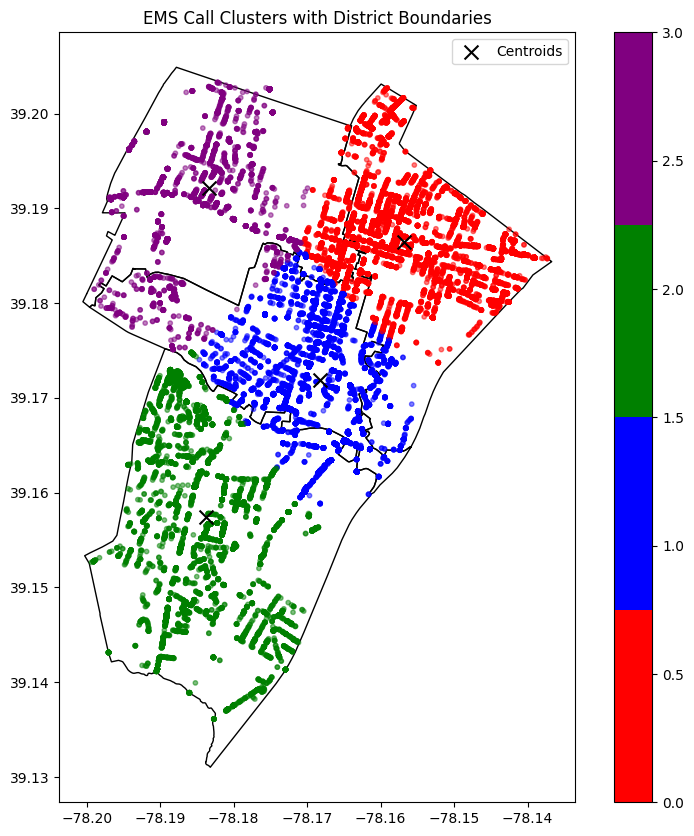

In [101]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Load geojson boundary file
districts = gpd.read_file("../data/First_Due_Areas.geojson")

# Convert call points to GeoDataFrame
calls_gdf = gpd.GeoDataFrame(
    calls_long_lat,
    geometry=gpd.points_from_xy(calls_long_lat['Longitude'], calls_long_lat['Latitude']),
    crs="EPSG:4326"
)

# Convert centroids to GeoDataFrame (longitude comes first!)
centroid_gdf = gpd.GeoDataFrame(
    centroid_df,
    geometry=gpd.points_from_xy(centroid_df['Longitude'], centroid_df['Latitude']),
    crs="EPSG:4326"
)

# Plot everything
fig, ax = plt.subplots(figsize=(10, 10))
districts.plot(ax=ax, edgecolor='black', facecolor='none')
custom_cmap = ListedColormap(['red', 'blue', 'green', 'purple'])  # match your cluster count
calls_gdf.plot(ax=ax, column='cluster', cmap=custom_cmap, markersize=10, alpha=0.5, legend=True)
# calls_gdf.plot(ax=ax, column='cluster', cmap='Set1', markersize=10, alpha=0.5, legend=True)
centroid_gdf.plot(ax=ax, color='black', markersize=100, marker='x', label='Centroids')

plt.title("EMS Call Clusters with District Boundaries")
plt.legend()
plt.show()


In [102]:
calls_long_lat.head()

calls_long_lat['cluster'].value_counts()

cluster
0    15052
1    11908
2    10885
3     5164
Name: count, dtype: int64

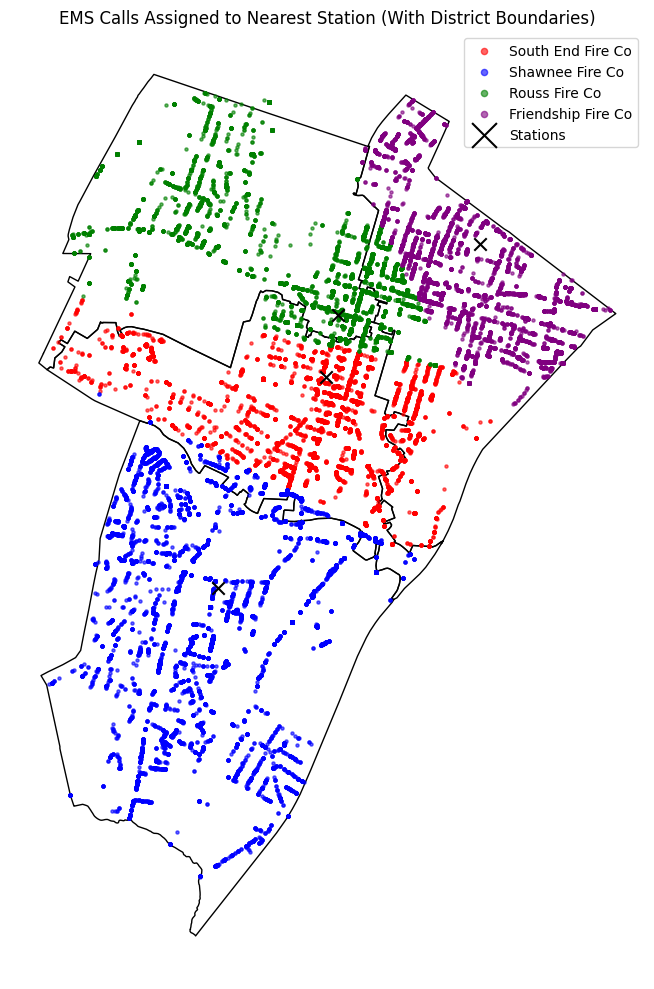

In [106]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from scipy.spatial import cKDTree
from matplotlib.colors import ListedColormap
import json

# Step 1: Load EMS call points (WGS84)
calls_gdf = gpd.GeoDataFrame(
    calls_long_lat,
    geometry=gpd.points_from_xy(calls_long_lat['Longitude'], calls_long_lat['Latitude']),
    crs="EPSG:4326"
)

# Step 2: Load station GeoJSON (WGS84)
with open("../data/Fire_Stations.geojson") as f:
    station_geojson = json.load(f)
stations_gdf = gpd.GeoDataFrame.from_features(station_geojson["features"], crs="EPSG:4326")

# Step 3: Project both to UTM for distance accuracy
projected_crs = "EPSG:26917"
calls_proj = calls_gdf.to_crs(projected_crs)
stations_proj = stations_gdf.to_crs(projected_crs)

# Step 4: Assign each call to the nearest station using cKDTree
station_coords = np.array(list(zip(stations_proj.geometry.x, stations_proj.geometry.y)))
call_coords = np.array(list(zip(calls_proj.geometry.x, calls_proj.geometry.y)))
tree = cKDTree(station_coords)
_, indices = tree.query(call_coords)
assigned_names = stations_proj.iloc[indices]["NAME"].values
calls_proj["nearest_station"] = assigned_names

# Step 5: Reproject everything back to WGS84 for display
calls_final = calls_proj.to_crs("EPSG:4326")
stations_final = stations_proj.to_crs("EPSG:4326")

# Step 6: Load and plot old district polygons
districts = gpd.read_file("../data/First_Due_Areas.geojson").to_crs("EPSG:4326")

# Step 7: Plot — EMS calls colored by nearest station
unique_stations = calls_final["nearest_station"].unique()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # expand if needed
station_color_map = dict(zip(unique_stations, colors[:len(unique_stations)]))

fig, ax = plt.subplots(figsize=(10, 10))
districts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

for station in unique_stations:
    calls_final[calls_final["nearest_station"] == station].plot(
        ax=ax,
        color=station_color_map[station],
        markersize=5,
        label=station,
        alpha=0.6
    )

stations_final.plot(ax=ax, color="black", markersize=80, label="Stations", marker="x")

plt.title("EMS Calls Assigned to Nearest Station (With District Boundaries)")
plt.legend(markerscale=2)
plt.axis("off")
plt.tight_layout()
plt.show()


In [108]:
calls_final.head()

calls_final[['nearest_station']].value_counts()

nearest_station   
Shawnee Fire Co       14415
Rouss Fire Co         11328
South End Fire Co      8660
Friendship Fire Co     8606
Name: count, dtype: int64

In [109]:
calls_by_district = pd.read_csv('../data/clean/calls_by_district.csv')
calls_by_district[['NAME']].value_counts()

NAME      
FRIENDSHIP    12595
SHAWNEE       12511
SOUTH END     10795
ROUSS          6782
Name: count, dtype: int64

NAME       weekday    week_of_year  time_segment
SOUTH END  Friday     18            AFTERNOON_3     26
SHAWNEE    Friday     50            AFTERNOON_3     20
SOUTH END  Friday     18            AFTERNOON_2     20
SHAWNEE    Friday     17            AFTERNOON_2     19
           Tuesday    51            MORNING_4       17
                                                    ..
SOUTH END  Sunday     32            MORNING_4        1
                                    MORNING_3        1
                                    MORNING_2        1
           Friday     38            MORNING_3        1
           Wednesday  53            MORNING_1        1
Name: count, Length: 10710, dtype: int64